In [158]:
import openeo
# import ProcessBuilder functions
from openeo.processes import ProcessBuilder
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import geopandas as gpd
import os

# Establish connection

In [129]:
# Establish a connection to openeo
connection = openeo.connect("openeofed.dataspace.copernicus.eu")
connection.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeofed.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

# Read Belgium Shapefile

<Axes: >

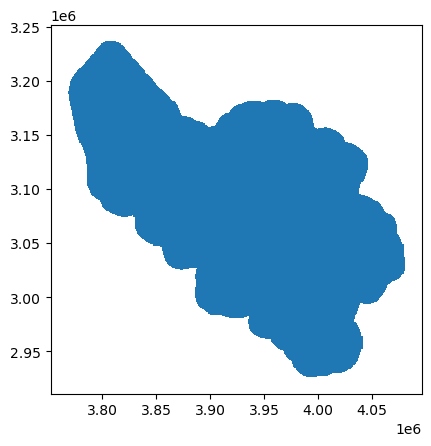

In [130]:
beShape = gpd.read_file("../../data/Belgium_shapefile/be_1km.shp")
beShape.plot()

In [131]:
beShape

,CELLCODE,EOFORIGIN,NOFORIGIN,geometry
0,1kmE3768N3188,3768000,3188000,"POLYGON ((3768000 3188000, 3768000 3189000, 37..."
1,1kmE3768N3189,3768000,3189000,"POLYGON ((3768000 3189000, 3768000 3190000, 37..."
2,1kmE3768N3190,3768000,3190000,"POLYGON ((3768000 3190000, 3768000 3191000, 37..."
3,1kmE3769N3182,3769000,3182000,"POLYGON ((3769000 3182000, 3769000 3183000, 37..."
4,1kmE3769N3183,3769000,3183000,"POLYGON ((3769000 3183000, 3769000 3184000, 37..."
...,...,...,...,...
51721,1kmE4079N3032,4079000,3032000,"POLYGON ((4079000 3032000, 4079000 3033000, 40..."
51722,1kmE4079N3033,4079000,3033000,"POLYGON ((4079000 3033000, 4079000 3034000, 40..."
51723,1kmE4079N3034,4079000,3034000,"POLYGON ((4079000 3034000, 4079000 3035000, 40..."
51724,1kmE4079N3035,4079000,3035000,"POLYGON ((4079000 3035000, 4079000 3036000, 40..."


The geometry is currently in a reference system that is not accepted by openeo. As such we are required to reproject the dataframe to the EPSG:4326 reference system

In [132]:
beShape=beShape.to_crs("EPSG:4326")
beShape

,CELLCODE,EOFORIGIN,NOFORIGIN,geometry
0,1kmE3768N3188,3768000,3188000,"POLYGON ((2.01272 51.52997, 2.01115 51.5389, 2..."
1,1kmE3768N3189,3768000,3189000,"POLYGON ((2.01115 51.5389, 2.00957 51.54782, 2..."
2,1kmE3768N3190,3768000,3190000,"POLYGON ((2.00957 51.54782, 2.008 51.55675, 2...."
3,1kmE3769N3182,3769000,3182000,"POLYGON ((2.03646 51.47739, 2.03489 51.48632, ..."
4,1kmE3769N3183,3769000,3183000,"POLYGON ((2.03489 51.48632, 2.03333 51.49525, ..."
...,...,...,...,...
51721,1kmE4079N3032,4079000,3032000,"POLYGON ((6.59875 50.34952, 6.59811 50.3585, 6..."
51722,1kmE4079N3033,4079000,3033000,"POLYGON ((6.59811 50.3585, 6.59746 50.36748, 6..."
51723,1kmE4079N3034,4079000,3034000,"POLYGON ((6.59746 50.36748, 6.59682 50.37645, ..."
51724,1kmE4079N3035,4079000,3035000,"POLYGON ((6.59682 50.37645, 6.59617 50.38543, ..."


The shapefile represents a grid of evenly sampled points within the boundary. In order to extract the border we must merge the cells contained in the shape file using the unary union operation. Extracting the boundary of this polygon can then be achieved easilty using the .boundary method.

C:\Users\niels\AppData\Local\Temp\ipykernel_29024\2354760973.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  merged_geometry = beShape.geometry.unary_union


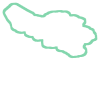

In [133]:
merged_geometry = beShape.geometry.unary_union
merged_geometry.boundary

In order to be useful in openeo we must convert this into a geoJSON object which is possible through the geo_interface method. Additional simplification of the geometry's border can be achieved using the simplify mmethod

In [134]:
boundary_geojson = merged_geometry.boundary.__geo_interface__

In [92]:
len(boundary_geojson["coordinates"])

1359

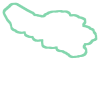

In [135]:
simplified_boundary = merged_geometry.boundary.simplify(tolerance=.001)
simplified_boundary

In [140]:
simplifiedGeoJson = simplified_boundary.__geo_interface__
simplifiedGeoJson

{'type': 'LineString',
 'coordinates': ((2.1593357948281544, 51.268955979218404),
  (2.1578052395613665, 51.27788478553902),
  (2.143543622085952, 51.276920571741826),
  (2.1358661271242974, 51.32156285709562),
  (2.1215913993077673, 51.32059581976408),
  (2.1154251309092547, 51.35630798028218),
  (2.1011400064158776, 51.35533833004752),
  (2.0934017206438433, 51.39997644299101),
  (2.0791034376352044, 51.399003957416475),
  (2.0728883637416198, 51.43471277496356),
  (2.058579646549622, 51.43373766637205),
  (2.050780136924339, 51.47837159421072),
  (2.036458212831407, 51.477393638401885),
  (2.027057325427686, 51.5309515686743),
  (2.0127194034594056, 51.52997053865273),
  (2.0080004194663563, 51.556748243376376),
  (2.022346640237434, 51.55772993575152),
  (2.014480276318163, 51.60235966476257),
  (2.0288409249709933, 51.60334070542839),
  (2.0225452070256593, 51.63904458194779),
  (2.0369175380046514, 51.64002474846701),
  (2.0337706601500525, 51.65787686669263),
  (2.04814912644345

Extract the linestring and convert it to a polygon. Ensure that the reference system is the one utilized by openeo

In [141]:
gdf = gpd.GeoDataFrame({'geometry': [simplified_boundary.buffer(0.0001)]})
gdf.set_crs('EPSG:4326', allow_override=True, inplace=True)  # Ensure the CRS is EPSG:4326 (WGS 84)

# Convert the GeoDataFrame geometry to GeoJSON
geojson = gdf.geometry.to_json()

# Sampling Satellite data within Belgium

In [253]:
belgiumSpatial = {"west": 2.537842, "south": 49.500242, "east": 6.388550, "north": 51.515580}
datacubeBE = connection.load_collection( #Access the different available collections
    "SENTINEL2_L2A", #Specify the collection name
    spatial_extent=belgiumSpatial, #Define a spatial window
    temporal_extent = ["2021-01-01", "2022-01-01"], # Define a temporal window
    bands=["B04","B03", "B02","B05", "B08", "B11", "SCL"] # Define which measured bands are required. 
)

Sentinel 2 offers the so called **Scene Classification Layer** which assigns a label to each of the pixels obtained from a satellite image.

| **Value** | **Label**                                 |
|-----------|--------------------------------------------|
| 0         | No data                                    |
| 1         | Saturated or defective                     |
| 2         | Dark area pixels                           |
| 3         | Cloud shadows                              |
| 4         | Vegetation                                 |
| 5         | Bare soils                                 |
| 6         | Water                                      |
| 7         | Cloud low probability / Unclassified       |
| 8         | Cloud medium probability                   |
| 9         | Cloud high probability                     |
| 10        | Thin cirrus                                |
| 11        | Snow or ice                                |

The labels extracted from the SCL can then be used to construct a mask that removes all specific occurences of a specific class.

In [254]:
def maskClouds(cube):
    sclBand = cube.band("SCL")
    cube_mask = ~ ((sclBand == 4) | (sclBand == 5) | (sclBand==6)) #NOT (SCL==4 OR SCL==5 OR SCL==6)
    return cube.mask(cube_mask)

In [255]:
datacubeBE = datacubeBE.resample_spatial(100, method="bilinear")

In [256]:
datacubeBE = maskClouds(datacubeBE)
datacubeBE

In [257]:
datacubeBE=datacubeBE.reduce_dimension(dimension="t", reducer="median")
datacubeBE

In [258]:
res = datacubeBE.save_result(format = "GTIFF")

# send job to back-end
job = res.create_job(title = "beS2_med")
job.start_and_wait()
job.get_results().download_files("beS2_med")

0:00:00 Job 'cdse-j-2504241156004571be866521edfdb579': send 'start'
0:00:13 Job 'cdse-j-2504241156004571be866521edfdb579': queued (progress 0%)
0:00:18 Job 'cdse-j-2504241156004571be866521edfdb579': queued (progress 0%)
0:00:25 Job 'cdse-j-2504241156004571be866521edfdb579': queued (progress 0%)
0:00:33 Job 'cdse-j-2504241156004571be866521edfdb579': queued (progress 0%)
0:00:43 Job 'cdse-j-2504241156004571be866521edfdb579': queued (progress 0%)
0:00:56 Job 'cdse-j-2504241156004571be866521edfdb579': queued (progress 0%)
0:01:11 Job 'cdse-j-2504241156004571be866521edfdb579': running (progress N/A)
0:01:31 Job 'cdse-j-2504241156004571be866521edfdb579': running (progress N/A)
0:01:55 Job 'cdse-j-2504241156004571be866521edfdb579': running (progress N/A)
0:02:25 Job 'cdse-j-2504241156004571be866521edfdb579': running (progress N/A)
0:03:02 Job 'cdse-j-2504241156004571be866521edfdb579': running (progress N/A)
0:03:49 Job 'cdse-j-2504241156004571be866521edfdb579': running (progress N/A)
0:04:48 

[WindowsPath('beS2_med/openEO.tif'), WindowsPath('beS2_med/job-results.json')]

# Visualize data within the Belgium administrative border

In [263]:
# Open the GeoTIFF file
path = os.path.join("beS2_med", "openEO.tif")
with rasterio.open(path) as dataset:
    # Read the data into a numpy array
    data = dataset.read()
    data = np.nan_to_num(data, nan=0)

In [291]:
data.shape

(7, 2296, 2789)

In [266]:
def scaleValues(array, maxClip=4000):
    array=np.clip(array, 0,maxClip)
    array=(array/maxClip)*255
    return array

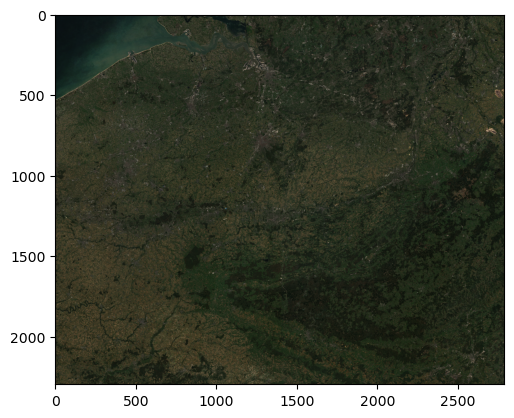

In [294]:
scaledData=scaleValues(data, maxClip=4000).astype(np.int16)
rgb = np.array([scaledData[0], scaledData[1], scaledData[2]])
plt.imshow(np.transpose(rgb,(1,2,0)))

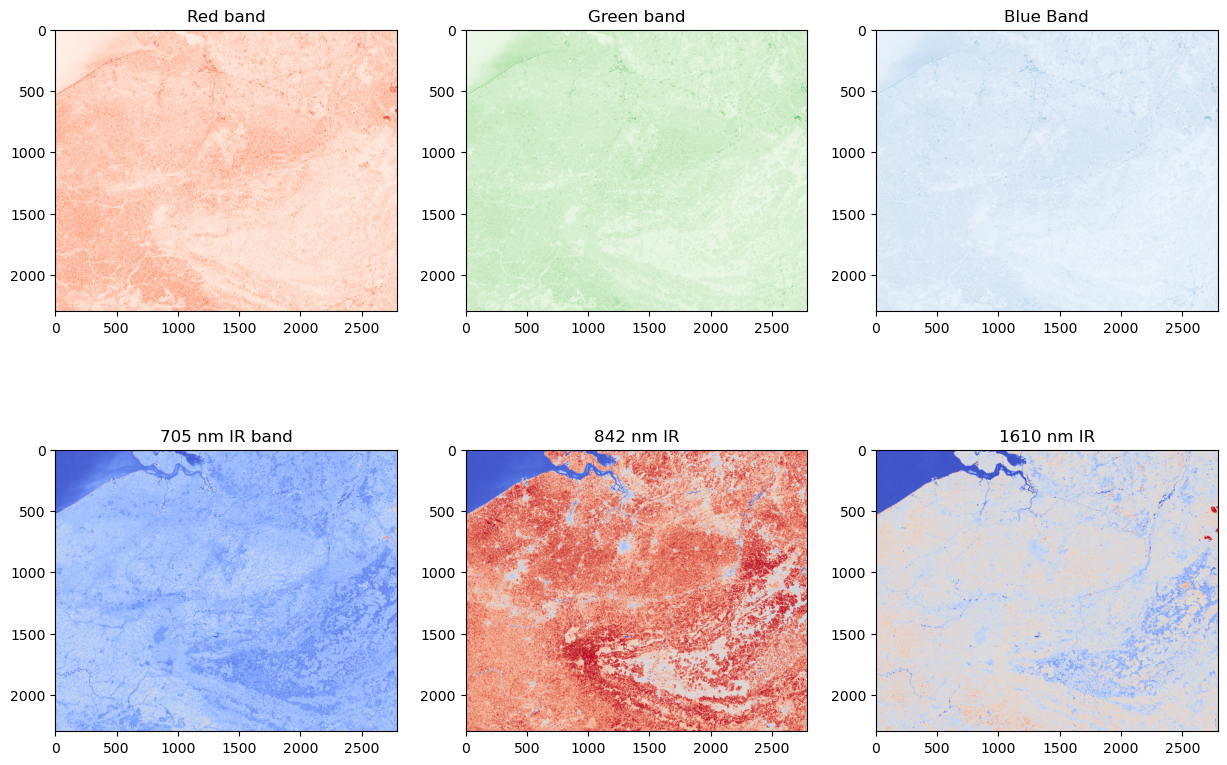

In [295]:
fig, axes = plt.subplots(2,3, figsize=(15,10))
titles=["Red band", "Green band", "Blue Band", "705 nm IR band", "842 nm IR", "1610 nm IR"]
cmaps=["Reds", "Greens", "Blues", "coolwarm", "coolwarm", "coolwarm"]
for ax, idx, title, cmap in zip(axes.flatten(), range(6), titles, cmaps):
    ax.imshow(scaledData[idx], cmap=cmap)
    ax.set_title(title)

plt.show()

# Worldcover data

In [299]:
connection.describe_collection("ESA_WORLDCOVER_10M_2021_V2")

{'assets': {},
 'cube:dimensions': {'bands': {'type': 'bands', 'values': ['MAP']},
  't': {'extent': ['2023-04-27T06:38:05Z', '2024-04-25T06:38:05Z'],
   'type': 'temporal'},
  'x': {'axis': 'x',
   'extent': [-180.0, 180.0],
   'step': 8.3333333333e-05,
   'type': 'spatial'},
  'y': {'axis': 'y',
   'extent': [-90.0, 90.0],
   'step': 8.3333333333e-05,
   'type': 'spatial'}},
 'description': 'WorldCover provides global land cover products for 2021 at 10 m resolution, developed and validated in near-real time based on Sentinel-1 and Sentinel-2 data. ',
 'experimental': True,
 'extent': {'spatial': {'bbox': [[-180.0, -90.0, 180.0, 90.0]]},
  'temporal': {'interval': [['2023-04-27T06:38:05Z',
     '2024-04-25T06:38:05Z']]}},
 'id': 'ESA_WORLDCOVER_10M_2021_V2',
 'item_assets': {'MAP': {'description': 'classification band',
   'eo:bands': [{'description': 'Classification', 'name': 'MAP'}],
   'roles': ['data'],
   'title': 'MAP',
   'type': 'image/tiff; application=geotiff'}},
 'keywords': ['VITO',
  'COPERNICUS',
  'ESA',
  'Land Cover',
  'Sentinel-1',
  'Sentinel-2',
  'Environment',
  'WorldCover'],
 'license': 'CC-BY-4.0',
 'links': [{'href': 'https://esa-worldcover.org/',
   'rel': 'alternate',
   'title': 'Product website'},
  {'href': 'https://services.terrascope.be/catalogue/description?collection=urn:eop:VITO:ESA_WorldCover_10m_2021_V2',
   'rel': 'alternate',
   'title': 'EO OpenSearch catalog'},
  {'href': 'https://viewer.esa-worldcover.org/worldcover',
   'rel': 'alternate',
   'title': 'Product Viewer'},
  {'href': 'https://services.terrascope.be/wmts/v2',
   'rel': 'wmts',
   'wmts:layer': 'WORLDCOVER_2021_MAP'},
  {'href': 'https://openeofed.dataspace.copernicus.eu/openeo/1.2/collections',
   'rel': 'root'},
  {'href': 'https://openeofed.dataspace.copernicus.eu/openeo/1.2/collections',
   'rel': 'parent'},
  {'href': 'https://openeofed.dataspace.copernicus.eu/openeo/1.2/collections/ESA_WORLDCOVER_10M_2021_V2',
   'rel': 'self'}],
 'providers': [{'name': 'VITO',
   'roles': ['producer'],
   'url': 'https://remotesensing.vito.be/'},
  {'name': 'ESA', 'roles': ['licensor'], 'url': 'https://esa.int/'}],
 'stac_extensions': ['https://stac-extensions.github.io/item-assets/v1.0.0/schema.json',
  'https://stac-extensions.github.io/raster/v1.1.0/schema.json',
  'https://stac-extensions.github.io/classification/v1.0.0/schema.json'],
 'stac_version': '1.0.0',
 'summaries': {'eo:bands': [{'gsd': 10, 'name': 'MAP', 'type': 'uint8'}],
  'federation:backends': ['cdse']},
 'title': 'Global landcover at 10m resolution for 2021.',
 'type': 'Collection'}

In [313]:
beWorldCover = connection.load_collection( #Access the different available collections
    "ESA_WORLDCOVER_10M_2021_V2", #Specify the collection name
    spatial_extent=belgiumSpatial, #Define a spatial window
    temporal_extent=["2021-01-01", "2021-12-31"], # Define a temporal window
    bands=["classification"] # Define which measured bands are required. 
)

ValueError: Invalid band name/index 'classification'. Valid names: ['MAP']

In [311]:
beWorldCover = beWorldCover.resample_spatial(100, method="bilinear")

In [312]:
res = beWorldCover.save_result(format = "GTIFF")

# send job to back-end
job = res.create_job(title = "beWC")
job.start_and_wait()
job.get_results().download_files("beWC")

0:00:00 Job 'cdse-j-25042413544844c39da7f74f0dd1af18': send 'start'
0:00:15 Job 'cdse-j-25042413544844c39da7f74f0dd1af18': created (progress 0%)
0:00:20 Job 'cdse-j-25042413544844c39da7f74f0dd1af18': queued (progress 0%)
0:00:26 Job 'cdse-j-25042413544844c39da7f74f0dd1af18': queued (progress 0%)
0:00:35 Job 'cdse-j-25042413544844c39da7f74f0dd1af18': queued (progress 0%)
0:00:45 Job 'cdse-j-25042413544844c39da7f74f0dd1af18': queued (progress 0%)
0:00:57 Job 'cdse-j-25042413544844c39da7f74f0dd1af18': queued (progress 0%)
0:01:13 Job 'cdse-j-25042413544844c39da7f74f0dd1af18': queued (progress 0%)
0:01:32 Job 'cdse-j-25042413544844c39da7f74f0dd1af18': running (progress N/A)
0:01:57 Job 'cdse-j-25042413544844c39da7f74f0dd1af18': running (progress N/A)
0:02:27 Job 'cdse-j-25042413544844c39da7f74f0dd1af18': running (progress N/A)
0:03:05 Job 'cdse-j-25042413544844c39da7f74f0dd1af18': running (progress N/A)
0:03:52 Job 'cdse-j-25042413544844c39da7f74f0dd1af18': finished (progress 100%)


No assets found in job result metadata.


[WindowsPath('beWC/job-results.json')]